In [2]:
import os
import pandas as pd
import json
from tqdm import tqdm
import torch
from torch_geometric.data import HeteroData

# --- 1. Define the path to your data ---
dataset_name = 'spotify-million-playlist'
base_path = f'/kaggle/input/{dataset_name}'

# --- 2. Get a list of all JSON files to process ---
json_files = [f for f in os.listdir(base_path) if f.endswith('.json')]
print(f"Found {len(json_files)} JSON files to process.")

# --- 3. Loop through files, process them, and store in a list ---
all_dfs = []

for file_name in tqdm(json_files, desc="Processing files"):
    file_path = os.path.join(base_path, file_name)
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    playlists_df = pd.json_normalize(data['playlists'])
    tracks_df = playlists_df.explode('tracks')

    if not tracks_df.empty and 'tracks' in tracks_df.columns and tracks_df['tracks'].notna().any():
        tracks_normalized_df = pd.json_normalize(tracks_df['tracks'])
        
        temp_df = pd.concat([
            tracks_df[['pid', 'name']].reset_index(drop=True),
            tracks_normalized_df.reset_index(drop=True)
        ], axis=1)
        
        all_dfs.append(temp_df)

# --- 4. Concatenate all DataFrames into one ---
final_df = None
if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
    print("\n--- Combined Song-Playlist DataFrame ---")
    print(f"Total rows in final DataFrame: {len(final_df)}")
else:
    print("No data was processed.")

# --- 5. Clean, Load, and Merge with Features ---
if final_df is not None:
    print("\nCleaning track_uri to match track_id...")
    # This removes 'spotify:track:' from the start of the string
    final_df['track_uri'] = final_df['track_uri'].str.split(':').str[-1]
    print("Cleaning complete. 'track_uri' column now contains only the ID.")

    try:
        # Load the features dataset
        # NOTE: Manually add this dataset to your Kaggle notebook first
        track_features_df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
        
        # Perform the left merge
        enriched_df = pd.merge(
            final_df, 
            track_features_df, 
            left_on='track_uri', 
            right_on='track_id', 
            how='left'
        )

        print("\n--- Merge Successful ---")
        print("Enriched DataFrame with Audio Features:")
        print(enriched_df.head())

        # Save the result for the next step
        enriched_df.to_csv('enriched_spotify_data.csv', index=False)
        print("\nSuccessfully saved the complete, enriched data to 'enriched_spotify_data.csv'")

    except FileNotFoundError:
        print(f"\nERROR: 'dataset.csv' not found in {base_path}")
        print("Please ensure you have manually added the features dataset to your Kaggle input files.")
    except Exception as e:
        print(f"An error occurred during the merge: {e}")

Found 150 JSON files to process.


Processing files: 100%|██████████| 150/150 [01:54<00:00,  1.31it/s]



--- Combined Song-Playlist DataFrame ---
Total rows in final DataFrame: 9968658

Cleaning track_uri to match track_id...
Cleaning complete. 'track_uri' column now contains only the ID.

--- Merge Successful ---
Enriched DataFrame with Audio Features:
      pid             name  pos          artist_name               track_uri  \
0  405000  old school jams    0  The Black Eyed Peas  2WNVqZq1ujhMDlOAqBFkVv   
1  405000  old school jams    1        Bubba Sparxxx  0k6HUzaRHpQ3eEWr1C7Esh   
2  405000  old school jams    2             Ginuwine  5XO5UiZmVaLFMFs1VaaxT5   
3  405000  old school jams    3             Mystikal  1jRzdY7oUBOhrylNtiMtBD   
4  405000  old school jams    4               T-Pain  1lih9AUGlOI2qbAkptdBsr   

                              artist_uri  \
0  spotify:artist:1yxSLGMDHlW21z4YXirZDS   
1  spotify:artist:3RPYHNSwe3w0mtfJwKIN9P   
2  spotify:artist:7r8RF1tN2A4CiGEplkp1oP   
3  spotify:artist:3LIJJJkO7R5RasRwt7xIn5   
4  spotify:artist:3aQeKQSyrW4qWr35idm0cy   

  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



Successfully saved the complete, enriched data to 'enriched_spotify_data.csv'


In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Clean dataframe by dropping NaN rows
cleaned_df = enriched_df.dropna()

# Export cleaned dataframe to CSV
cleaned_df.to_csv("cleaned_playlists_and_tracks.csv", index=False)

print("✅ Cleaned DataFrame exported to cleaned_tracks.csv")


✅ Cleaned DataFrame exported to cleaned_tracks.csv


In [4]:
reloaded_df = pd.read_csv("cleaned_playlists_and_tracks.csv")
print(len(reloaded_df))
print(reloaded_df.head())

1830240
      pid             name  pos           artist_name               track_uri  \
0  405000  old school jams   10  The Notorious B.I.G.  7KwZNVEaqikRSBSpyhXK2j   
1  405000  old school jams   19  The Notorious B.I.G.  2g8HN35AnVGIk7B8yMucww   
2  405000  old school jams   22            Snoop Dogg  2NBQmPrOEEjA8VbeWOQGxO   
3  405000  old school jams   32           Blackstreet  6MdqqkQ8sSC0WB4i8PyRuQ   
4  405000  old school jams   32           Blackstreet  6MdqqkQ8sSC0WB4i8PyRuQ   

                              artist_uri                         track_name_x  \
0  spotify:artist:5me0Irg2ANcsgc93uaYrpb  Hypnotize - 2014 Remastered Version   
1  spotify:artist:5me0Irg2ANcsgc93uaYrpb                            Big Poppa   
2  spotify:artist:7hJcb9fa4alzcOq3EaNPoG                Drop It Like It's Hot   
3  spotify:artist:2P3cjUru4H3fhSXXNxE9kA                           No Diggity   
4  spotify:artist:2P3cjUru4H3fhSXXNxE9kA                           No Diggity   

                  

In [8]:

cleaned_df = pd.read_csv('cleaned_playlists_and_tracks.csv')

print("Starting graph construction...")

# --- Step 1: Create Node Mappings ---
# Create unique integer indices for each song and playlist
unique_track_uris = cleaned_df['track_uri'].unique()
unique_pids = cleaned_df['pid'].unique()

song_mapping = {uri: i for i, uri in enumerate(unique_track_uris)}
# playlist_mapping = {pid: i for i, pid in enumerate(unique_pids)}
playlist_mapping = {int(pid): i for i, pid in enumerate(unique_pids)}

# --- Step 2: Extract Node Features (for 'song' nodes) ---
# First, get a DataFrame with one row per unique song
unique_songs_df = cleaned_df.drop_duplicates(subset='track_uri').sort_values('track_uri')

# Define your numerical feature columns
feature_cols = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity'
]
# Ensure all feature columns exist and are numeric
existing_feature_cols = [col for col in feature_cols if col in unique_songs_df.columns]
song_features = unique_songs_df[existing_feature_cols].to_numpy()

# Convert features to a PyTorch tensor
song_features_tensor = torch.tensor(song_features, dtype=torch.float32)
print(f"Created song features tensor of shape: {song_features_tensor.shape}")

# --- Step 3: Create Edge Indices ---
# Map the URIs and PIDs in the main DataFrame to their integer indices
song_indices = cleaned_df['track_uri'].map(song_mapping).to_numpy()
playlist_indices = cleaned_df['pid'].map(playlist_mapping).to_numpy()

# Create the edge index tensor for the ('song', 'belongs_to', 'playlist') relation
edge_index_song_to_playlist = torch.tensor([song_indices, playlist_indices], dtype=torch.long)
print(f"Created edge index tensor of shape: {edge_index_song_to_playlist.shape}")

# --- Step 4: Assemble the HeteroData Object ---
data = HeteroData()

# Add song node data
data['song'].x = song_features_tensor

# Add playlist node data (no features, just the node count)
data['playlist'].num_nodes = len(unique_pids)

# Add edge data for both directions
data['song', 'belongs_to', 'playlist'].edge_index = edge_index_song_to_playlist
data['playlist', 'contains', 'song'].edge_index = edge_index_song_to_playlist.flip([0]) # Flipped for reverse direction

print("\n--- Graph Summary ---")
print(data)
print("Graph object created successfully!")

# --- Step 5: Save the Graph and Mappings ---
torch.save(data, 'graph_data.pt')
print("\nGraph object saved to 'graph_data.pt'")

with open('song_mapping.json', 'w') as f:
    json.dump(song_mapping, f)
with open('playlist_mapping.json', 'w') as f:
    json.dump(playlist_mapping, f)
print("Node mappings saved to JSON files.")

Starting graph construction...
Created song features tensor of shape: torch.Size([8261, 10])
Created edge index tensor of shape: torch.Size([2, 1830240])

--- Graph Summary ---
HeteroData(
  song={ x=[8261, 10] },
  playlist={ num_nodes=126555 },
  (song, belongs_to, playlist)={ edge_index=[2, 1830240] },
  (playlist, contains, song)={ edge_index=[2, 1830240] }
)
Graph object created successfully!

Graph object saved to 'graph_data.pt'
Node mappings saved to JSON files.


In [9]:
pip install networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


Plotting subgraph for Playlist ID: 405000
It contains 2158 songs.


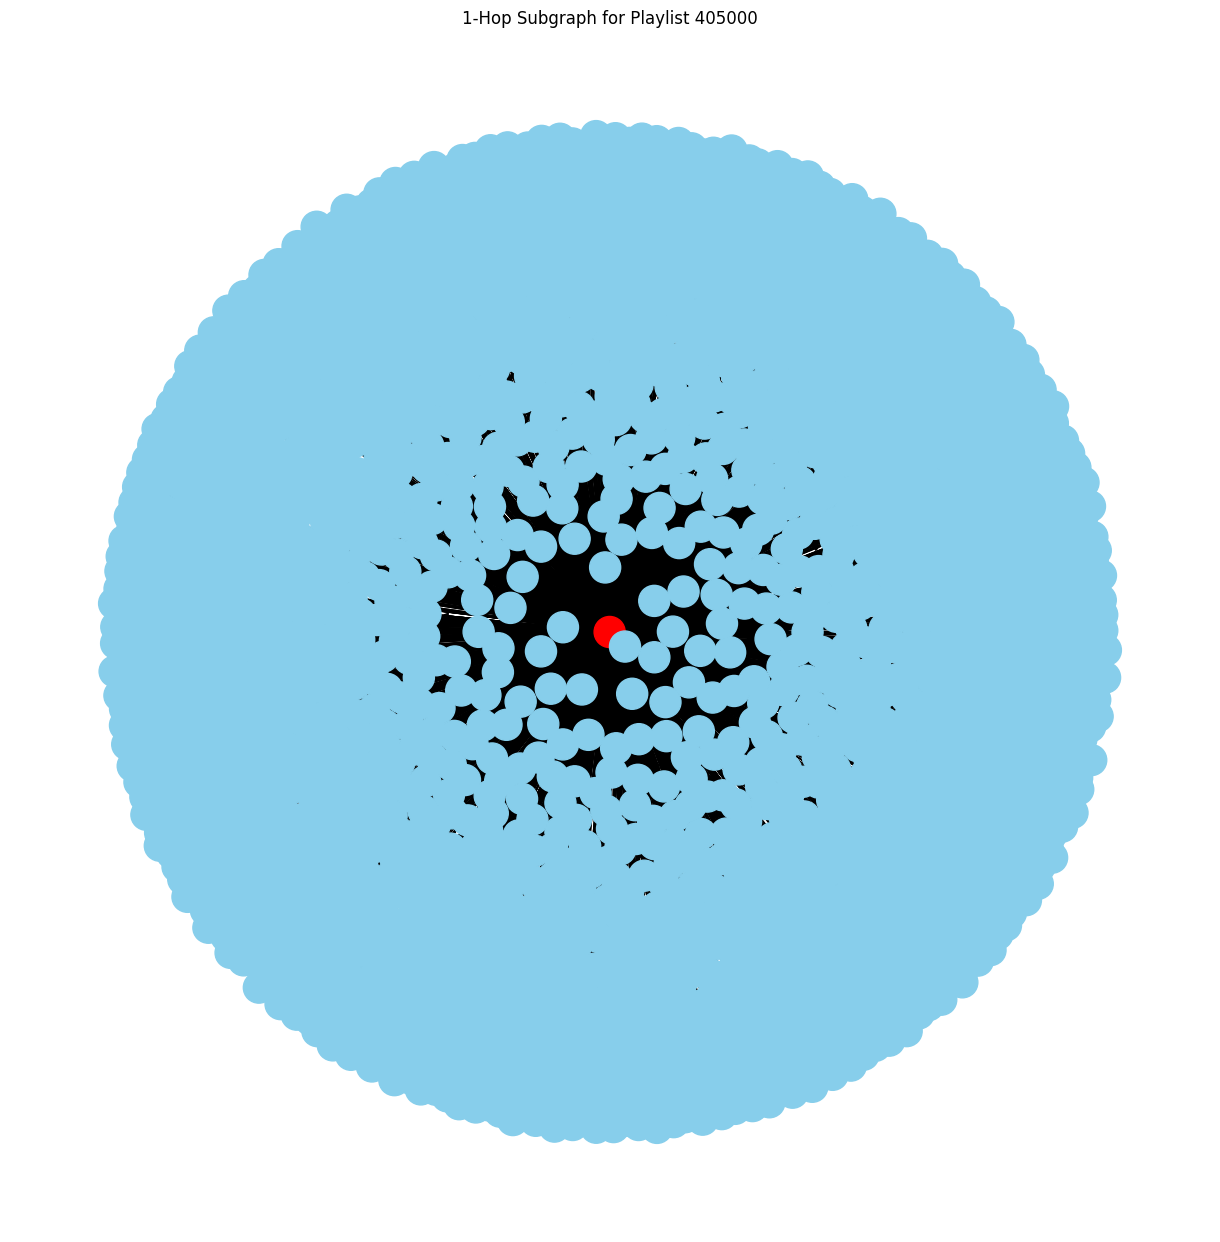

In [10]:
import torch
import json
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils
from torch_geometric.utils import to_networkx
from torch_geometric.data import HeteroData, Data

# --- 1. Install networkx if you haven't already ---
# You might need to run this in a separate cell:
# %pip install networkx matplotlib

# --- 2. Load the saved graph data ---
try:
    data = torch.load('graph_data.pt', weights_only=False)
    with open('playlist_mapping.json', 'r') as f:
        playlist_mapping = json.load(f)
    
    # Create a reverse mapping to find original PID from index
    inv_playlist_mapping = {v: k for k, v in playlist_mapping.items()}

    # --- 3. Specify a starting node and neighborhood size ---
    # We'll visualize the subgraph around the very first playlist (index 0)
    start_playlist_index = 0
    
    # Convert HeteroData to a standard Graph for k-hop subgraph
    # We only need one edge type for this conversion
    homogeneous_data = data.to_homogeneous()

    # Get the 1-hop subgraph (the playlist and its direct song neighbors)
    subset, edge_index, mapping, edge_mask = torch_geometric.utils.k_hop_subgraph(
        node_idx=start_playlist_index,
        num_hops=1,
        edge_index=homogeneous_data.edge_index,
        relabel_nodes=True # Renumbers nodes from 0 to N-1
    )

    # --- 4. Convert the subgraph to a NetworkX graph for plotting ---
    # We need to create a temporary PyG object for the subgraph to convert it
    subgraph_data = Data(edge_index=edge_index, num_nodes=subset.size(0))
    G = to_networkx(subgraph_data)

    # --- 5. Prepare for plotting ---
    plt.figure(figsize=(12, 12))
    
    # Determine colors for each node type
    colors = []
    node_labels = {}
    
    # The first node in our subset is always the central playlist
    colors.append('red') # Color for the playlist node
    original_pid = inv_playlist_mapping.get(start_playlist_index, "Unknown PID")
    node_labels[0] = f"Playlist {original_pid}"

    # All other nodes are songs
    for i in range(1, G.number_of_nodes()):
        colors.append('skyblue') # Color for song nodes

    print(f"Plotting subgraph for Playlist ID: {original_pid}")
    print(f"It contains {len(colors) - 1} songs.")

    # --- 6. Draw the graph ---
    nx.draw(G, with_labels=False, node_color=colors, node_size=500, font_size=8)
    # Add a title
    plt.title(f"1-Hop Subgraph for Playlist {original_pid}")
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure 'graph_data.pt' and 'playlist_mapping.json' are in the same directory.")

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.data import HeteroData

# --- 1. Define the GNN Encoder ---
# This network generates the embeddings for our nodes.
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # We define two SAGEConv layers for two steps of message passing
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        # The SAGEConv layer expects a single feature matrix and edge_index,
        # so we'll apply it within the HeteroConv wrapper.
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# --- 2. Define the main Model ---
# This class wraps our GNN and adds a decoder to predict links.
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        
        # The output of our encoder will be the final embedding for each node.
        out_channels = hidden_channels
        
        # Encoder for song nodes
        self.song_encoder = GNNEncoder(hidden_channels, out_channels)
        
        # We need a separate linear layer for playlists since they have no initial features.
        # This creates an initial "embedding" for each playlist before message passing.
        self.playlist_embed = torch.nn.Embedding(num_nodes_dict['playlist'], hidden_channels)

        # Our heterogeneous GNN that will apply the SAGEConv layers across node types
        self.conv = HeteroConv({
            ('song', 'belongs_to', 'playlist'): self.song_encoder,
            ('playlist', 'contains', 'song'): self.song_encoder,
        }, aggr='sum') # We can aggregate messages from different relation types, 'sum' is common.

    def forward(self, data: HeteroData):
        # Get the initial features for songs and the learnable embeddings for playlists
        x_dict = {
          "song": data["song"].x,
          "playlist": self.playlist_embed(data["playlist"].node_id),
        }
        
        # Pass the data through the heterogeneous GNN
        # This performs message passing and updates the node representations.
        x_dict = self.conv(x_dict, data.edge_index_dict)
        
        return x_dict

    def decode(self, song_embedding, playlist_embedding):
        # A simple dot product to predict the score of an edge
        return (song_embedding * playlist_embedding).sum(dim=-1)

# --- 3. Instantiate the Model ---
# First, we need to know how many playlists there are for the Embedding layer
# Let's assume you have the 'data' object loaded from the previous step
try:
    data = torch.load('graph_data.pt', weights_only=False)
    num_nodes_dict = {
        'playlist': data['playlist'].num_nodes,
        'song': data['song'].num_nodes
    }

    # Let's create the model
    model = Model(hidden_channels=64) # 64 is a common size for embeddings
    print("GNN Model created successfully:")
    print(model)

except FileNotFoundError:
    print("Please make sure 'graph_data.pt' is available to instantiate the model.")
except Exception as e:
    print(f"An error occurred: {e}")

GNN Model created successfully:
Model(
  (song_encoder): GNNEncoder(
    (conv1): SAGEConv((-1, -1), 64, aggr=mean)
    (conv2): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (playlist_embed): Embedding(126555, 64)
  (conv): HeteroConv(num_relations=2)
)


In [20]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, HeteroConv
from sklearn.metrics import roc_auc_score
import time

# --- 1. Setup GPU Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Model Definition (remains the same) ---
class Model(torch.nn.Module):
    def __init__(self, hidden_channels, num_playlists):
        super().__init__()
        self.playlist_embed = torch.nn.Embedding(num_playlists, hidden_channels)
        self.conv1 = HeteroConv({
            ('song', 'belongs_to', 'playlist'): SAGEConv((-1, -1), hidden_channels),
            ('playlist', 'contains', 'song'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('song', 'belongs_to', 'playlist'): SAGEConv(hidden_channels, hidden_channels),
            ('playlist', 'contains', 'song'): SAGEConv(hidden_channels, hidden_channels),
        }, aggr='sum')
    def forward(self, data):
        x_dict = {
          "song": data["song"].x,
          "playlist": self.playlist_embed(data["playlist"].node_id),
        }
        x_dict = self.conv1(x_dict, data.edge_index_dict)
        x_dict = {key: x.relu() for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, data.edge_index_dict)
        return x_dict
    def decode(self, song_embedding, playlist_embedding):
        return (song_embedding * playlist_embedding).sum(dim=-1)

# --- 3. Load Data and Move to GPU ---
print("Loading data...")
data = torch.load('graph_data.pt', weights_only=False)
data['playlist'].node_id = torch.arange(data['playlist'].num_nodes)

print("Splitting data...")
transform = T.RandomLinkSplit(
    num_val=0.1, num_test=0.1, is_undirected=True,
    add_negative_train_samples=True,
    edge_types=[('song', 'belongs_to', 'playlist')],
    rev_edge_types=[('playlist', 'contains', 'song')]
)
train_data, val_data, test_data = transform(data)

# Move all data splits to the selected device
print("Moving data to GPU...")
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)
print("Data moved successfully.")

# --- 4. Instantiate Model and Move to GPU ---
model = Model(
    hidden_channels=64, 
    num_playlists=data['playlist'].num_nodes
).to(device) # <-- Move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# --- 5. Train and Test Functions (no changes needed) ---
def train():
    model.train()
    optimizer.zero_grad()
    embeddings = model(train_data)
    
    edge_label_index = train_data['song', 'belongs_to', 'playlist'].edge_label_index
    edge_label = train_data['song', 'belongs_to', 'playlist'].edge_label
    
    pred = model.decode(
        embeddings['song'][edge_label_index[0]],
        embeddings['playlist'][edge_label_index[1]]
    )
    
    loss = F.binary_cross_entropy_with_logits(pred, edge_label)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test(data_split):
    model.eval()
    embeddings = model(data_split)
    
    edge_label_index = data_split['song', 'belongs_to', 'playlist'].edge_label_index
    edge_label = data_split['song', 'belongs_to', 'playlist'].edge_label
    
    pred = model.decode(
        embeddings['song'][edge_label_index[0]],
        embeddings['playlist'][edge_label_index[1]]
    ).sigmoid()
    
    # Move predictions and labels to CPU for scikit-learn
    return roc_auc_score(edge_label.cpu().numpy(), pred.cpu().numpy())

# --- 6. The Main Training Loop (300 Epochs) ---
print("\nStarting training for 300 epochs...")
start_time = time.time()
for epoch in range(1, 301):
    epoch_start_time = time.time()
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}, Time: {epoch_duration:.2f}s')

total_duration = time.time() - start_time
print(f"\nTraining complete in {total_duration / 60:.2f} minutes.")
torch.save(model.state_dict(), 'trained_model_weights_gpu.pt')
print("Trained model weights saved to 'trained_model_weights_gpu.pt'")

Using device: cuda
Loading data...
Splitting data...
Moving data to GPU...
Data moved successfully.

Starting training for 300 epochs...
Epoch: 001, Loss: 163.1758, Val AUC: 0.5051, Test AUC: 0.5009, Time: 0.24s
Epoch: 002, Loss: 6246.8301, Val AUC: 0.5069, Test AUC: 0.5013, Time: 0.23s
Epoch: 003, Loss: 1102.2313, Val AUC: 0.4952, Test AUC: 0.4991, Time: 0.23s
Epoch: 004, Loss: 5006.3271, Val AUC: 0.4938, Test AUC: 0.4988, Time: 0.23s
Epoch: 005, Loss: 4434.3306, Val AUC: 0.4931, Test AUC: 0.4987, Time: 0.23s
Epoch: 006, Loss: 2040.2754, Val AUC: 0.5018, Test AUC: 0.5002, Time: 0.23s
Epoch: 007, Loss: 324.7047, Val AUC: 0.5020, Test AUC: 0.5003, Time: 0.23s
Epoch: 008, Loss: 1055.9465, Val AUC: 0.5043, Test AUC: 0.5007, Time: 0.24s
Epoch: 009, Loss: 1034.8607, Val AUC: 0.5063, Test AUC: 0.5011, Time: 0.23s
Epoch: 010, Loss: 709.2560, Val AUC: 0.5067, Test AUC: 0.5012, Time: 0.23s
Epoch: 011, Loss: 324.3904, Val AUC: 0.4976, Test AUC: 0.4861, Time: 0.29s
Epoch: 012, Loss: 28.6911, Val 

In [22]:
# --- 1. Setup Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 2. Load All Necessary Artifacts ---
print("Loading artifacts...")
# Load the graph data
data = torch.load('graph_data.pt', weights_only=False).to(device)
data['playlist'].node_id = torch.arange(data['playlist'].num_nodes).to(device)

# Load the mappings
with open('song_mapping.json', 'r') as f:
    song_mapping = json.load(f)
with open('playlist_mapping.json', 'r') as f:
    playlist_mapping = json.load(f)

# Create reverse mappings to convert indices back to original IDs
inv_song_mapping = {v: k for k, v in song_mapping.items()}
inv_playlist_mapping = {v: k for k, v in playlist_mapping.items()}

# Load your cleaned, enriched DataFrame to get song names
try:
    enriched_df = pd.read_csv('cleaned_playlists_and_tracks.csv')
except FileNotFoundError:
    print("Warning: 'cleaned_playlists_and_tracks.csv' not found. Recommendations will be song URIs only.")
    enriched_df = None

# --- 3. Load the Trained Model ---
# Instantiate the model architecture
model = Model(
    hidden_channels=64,
    num_playlists=data['playlist'].num_nodes
).to(device)

# Load the trained weights
model.load_state_dict(torch.load('trained_model_weights_gpu.pt'))
model.eval() # Set the model to evaluation mode

# --- 4. Generate Final Embeddings ---
print("Generating final embeddings for all nodes...")
with torch.no_grad():
    final_embeddings = model(data)
    song_embeddings = final_embeddings['song']
    playlist_embeddings = final_embeddings['playlist']
print("Embeddings generated.")

# --- 5. The Recommendation Function ---
def get_recommendations(playlist_id, num_recommendations=10):
    """
    Generates song recommendations for a given playlist ID.
    """
    if str(playlist_id) not in playlist_mapping:
        return f"Playlist ID {playlist_id} not found in the dataset."

    # Get the integer index for the playlist
    playlist_idx = playlist_mapping[str(playlist_id)]
    
    # Get the embedding for that specific playlist
    playlist_emb = playlist_embeddings[playlist_idx]
    
    # Calculate similarity (dot product) between the playlist and all songs
    scores = song_embeddings @ playlist_emb
    
    # --- Filter out songs already in the playlist ---
    # Get original song URIs already in the playlist
    songs_in_playlist = set(enriched_df[enriched_df['pid'] == playlist_id]['track_uri'].unique())
    
    # Create a mask to exclude these songs
    mask = torch.ones(len(song_mapping), dtype=torch.bool)
    for uri in songs_in_playlist:
        if uri in song_mapping:
            song_idx = song_mapping[uri]
            mask[song_idx] = False
    
    # Apply the mask to the scores
    scores[~mask] = -torch.inf # Set score to negative infinity for existing songs
    
    # --- Get Top-N Recommendations ---
    top_k_scores, top_k_indices = torch.topk(scores, k=num_recommendations)
    
    # Convert indices back to original song URIs
    recommended_uris = [inv_song_mapping[idx.item()] for idx in top_k_indices]
    
    # Look up song names from the DataFrame
    if enriched_df is not None:
        recs_df = enriched_df[enriched_df['track_uri'].isin(recommended_uris)][['track_name_x', 'artists']].drop_duplicates()
        return recs_df
    else:
        return recommended_uris

# --- 6. Example Usage ---
example_playlist_id = 405000 # Use a PID from your dataset
recommendations = get_recommendations(example_playlist_id, num_recommendations=10)

print(f"\n--- Recommendations for Playlist {example_playlist_id} ---")
print(recommendations)

Using device: cuda
Loading artifacts...
Generating final embeddings for all nodes...
Embeddings generated.

--- Recommendations for Playlist 405000 ---
                                             track_name_x  \
234630                                    Mr. Sun Cho Lee   
389805                        Happy Together - Remastered   
448299                                         Boulmamine   
501552                                      Just Too Easy   
907259                                   Modern Wolf Hair   
1372442                    Gloom And How It Gets That Way   
1372922                                    React / Regret   
1469127  When You Bomb Several Countries Bad Shit Happens   
1716675                                 In The Night-Time   
1768466                                      El Dulcerito   

                            artists  
234630   Keola Beamer;Kapono Beamer  
389805                  The Turtles  
448299             Orchestra Baobab  
501552                  